### Imports

In [1]:
# 05_trees_and_tuning.ipynb - Tree Models & Hyperparameter Tuning
# Following ML Zoomcamp Week 6 methodology

import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

print("✅ Imports successful")

✅ Imports successful


### Load Data

In [2]:
# Load preprocessed splits
train = pd.read_csv("../data/processed/train.csv")
val = pd.read_csv("../data/processed/val.csv")
test = pd.read_csv("../data/processed/test.csv")

print("Data loaded:")
print(f"Train: {train.shape}")
print(f"Val:   {val.shape}")
print(f"Test:  {test.shape}")

Data loaded:
Train: (3066, 11)
Val:   (1022, 11)
Test:  (1022, 11)


### Data Preparation

In [3]:
# Handle missing BMI
train_bmi_median = train['bmi'].median()
train['bmi'] = train['bmi'].fillna(train_bmi_median)
val['bmi'] = val['bmi'].fillna(train_bmi_median)
test['bmi'] = test['bmi'].fillna(train_bmi_median)

# Separate features and target
X_train = train.drop(columns=['stroke'])
y_train = train['stroke']

X_val = val.drop(columns=['stroke'])
y_val = val['stroke']

X_test = test.drop(columns=['stroke'])
y_test = test['stroke']

print(f"✅ Data prepared: X_train {X_train.shape}")

✅ Data prepared: X_train (3066, 10)


### Define Preprocessor

In [4]:
# Feature types
numeric_cols = ['age', 'avg_glucose_level', 'bmi']
categorical_cols = ['gender', 'hypertension', 'heart_disease', 
                   'ever_married', 'work_type', 'Residence_type', 'smoking_status']

# Build preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='drop'
)

print("✅ Preprocessor defined")

✅ Preprocessor defined


### Baseline Random Forest (Untuned)

In [5]:
# Baseline Random Forest (from Module 03)
print("="*60)
print("BASELINE RANDOM FOREST (Untuned)")
print("="*60)

rf_baseline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=100,
        min_samples_leaf=50,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])

# Train
rf_baseline.fit(X_train, y_train)

# Evaluate
y_val_proba_baseline = rf_baseline.predict_proba(X_val)[:, 1]
baseline_auc = roc_auc_score(y_val, y_val_proba_baseline)

print(f"Baseline Validation ROC AUC: {baseline_auc:.4f}")

BASELINE RANDOM FOREST (Untuned)
Baseline Validation ROC AUC: 0.8366


### Hyperparameter Tuning - Decision Tree

In [6]:
# Decision Tree hyperparameter tuning
print("="*60)
print("DECISION TREE - HYPERPARAMETER TUNING")
print("="*60)

dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(class_weight='balanced', random_state=42))
])

# Parameter grid
dt_param_grid = {
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__min_samples_split': [50, 100, 200],
    'classifier__min_samples_leaf': [20, 50, 100]
}

# Grid search with stratified k-fold
dt_grid = GridSearchCV(
    dt_pipeline,
    dt_param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

print("Starting Grid Search for Decision Tree...")
dt_grid.fit(X_train, y_train)

print(f"\n✅ Best Decision Tree parameters: {dt_grid.best_params_}")
print(f"Best CV ROC AUC: {dt_grid.best_score_:.4f}")

# Evaluate on validation
y_val_proba_dt = dt_grid.predict_proba(X_val)[:, 1]
dt_val_auc = roc_auc_score(y_val, y_val_proba_dt)
print(f"Validation ROC AUC: {dt_val_auc:.4f}")

DECISION TREE - HYPERPARAMETER TUNING
Starting Grid Search for Decision Tree...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

✅ Best Decision Tree parameters: {'classifier__max_depth': 3, 'classifier__min_samples_leaf': 100, 'classifier__min_samples_split': 50}
Best CV ROC AUC: 0.8162
Validation ROC AUC: 0.7909


### Hyperparameter Tuning - Random Forest

In [7]:
# Random Forest hyperparameter tuning
print("="*60)
print("RANDOM FOREST - HYPERPARAMETER TUNING")
print("="*60)

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1))
])

# Parameter grid
rf_param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [5, 10, 15, None],
    'classifier__min_samples_split': [50, 100, 200],
    'classifier__min_samples_leaf': [20, 50, 100]
}

# Randomized search (faster than grid search)
rf_random = RandomizedSearchCV(
    rf_pipeline,
    rf_param_grid,
    n_iter=20,  # Try 20 random combinations
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("Starting Randomized Search for Random Forest...")
rf_random.fit(X_train, y_train)

print(f"\n✅ Best Random Forest parameters: {rf_random.best_params_}")
print(f"Best CV ROC AUC: {rf_random.best_score_:.4f}")

# Evaluate on validation
y_val_proba_rf = rf_random.predict_proba(X_val)[:, 1]
rf_val_auc = roc_auc_score(y_val, y_val_proba_rf)
print(f"Validation ROC AUC: {rf_val_auc:.4f}")

RANDOM FOREST - HYPERPARAMETER TUNING
Starting Randomized Search for Random Forest...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

✅ Best Random Forest parameters: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 100, 'classifier__min_samples_leaf': 50, 'classifier__max_depth': None}
Best CV ROC AUC: 0.8358
Validation ROC AUC: 0.8405


### Hyperparameter Tuning - Gradient Boosting

In [8]:
# Gradient Boosting hyperparameter tuning
print("="*60)
print("GRADIENT BOOSTING - HYPERPARAMETER TUNING")
print("="*60)

gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Parameter grid
gb_param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__max_depth': [3, 5, 7],
    'classifier__min_samples_split': [50, 100],
    'classifier__min_samples_leaf': [20, 50]
}

# Randomized search
gb_random = RandomizedSearchCV(
    gb_pipeline,
    gb_param_grid,
    n_iter=20,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("Starting Randomized Search for Gradient Boosting...")
gb_random.fit(X_train, y_train)

print(f"\n✅ Best Gradient Boosting parameters: {gb_random.best_params_}")
print(f"Best CV ROC AUC: {gb_random.best_score_:.4f}")

# Evaluate on validation
y_val_proba_gb = gb_random.predict_proba(X_val)[:, 1]
gb_val_auc = roc_auc_score(y_val, y_val_proba_gb)
print(f"Validation ROC AUC: {gb_val_auc:.4f}")

GRADIENT BOOSTING - HYPERPARAMETER TUNING
Starting Randomized Search for Gradient Boosting...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

✅ Best Gradient Boosting parameters: {'classifier__n_estimators': 50, 'classifier__min_samples_split': 100, 'classifier__min_samples_leaf': 50, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.1}
Best CV ROC AUC: 0.8332
Validation ROC AUC: 0.8523


### Compare All Tuned Models

MODEL COMPARISON - TUNED vs BASELINE
                    Model  Validation ROC AUC
Gradient Boosting (Tuned)            0.852335
    Random Forest (Tuned)            0.840514
 Random Forest (Baseline)            0.836564
    Decision Tree (Tuned)            0.790916


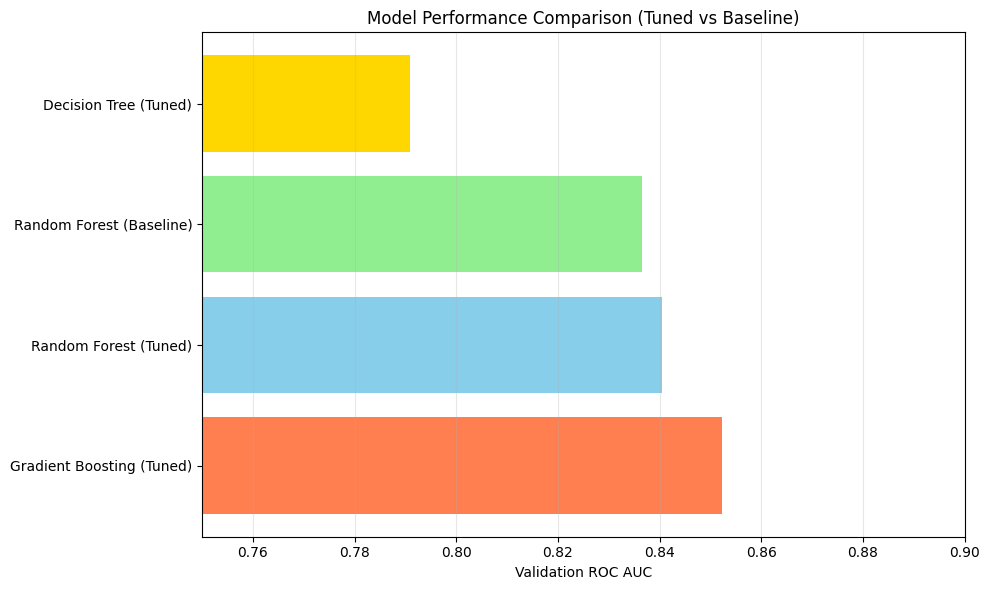

In [9]:
# Model comparison
results = pd.DataFrame({
    'Model': [
        'Random Forest (Baseline)',
        'Decision Tree (Tuned)',
        'Random Forest (Tuned)',
        'Gradient Boosting (Tuned)'
    ],
    'Validation ROC AUC': [
        baseline_auc,
        dt_val_auc,
        rf_val_auc,
        gb_val_auc
    ]
}).sort_values('Validation ROC AUC', ascending=False)

print("="*60)
print("MODEL COMPARISON - TUNED vs BASELINE")
print("="*60)
print(results.to_string(index=False))
print("="*60)

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(results['Model'], results['Validation ROC AUC'], color=['coral', 'skyblue', 'lightgreen', 'gold'])
plt.xlabel('Validation ROC AUC')
plt.title('Model Performance Comparison (Tuned vs Baseline)')
plt.xlim([0.75, 0.90])
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

### Final Model Evaluation on Test Set

In [10]:
# Select best model
best_model_name = results.iloc[0]['Model']
best_val_auc = results.iloc[0]['Validation ROC AUC']

print("="*60)
print("FINAL TEST SET EVALUATION")
print("="*60)
print(f"Best Model: {best_model_name}")
print(f"Validation AUC: {best_val_auc:.4f}")

# Get best model
if 'Decision Tree' in best_model_name:
    best_model = dt_grid.best_estimator_
elif 'Gradient Boosting' in best_model_name:
    best_model = gb_random.best_estimator_
else:
    best_model = rf_random.best_estimator_

# Evaluate on test set
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

test_auc = roc_auc_score(y_test, y_test_proba)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"\nTest Set Results:")
print(f"  ROC AUC:  {test_auc:.4f}")
print(f"  Accuracy: {test_acc:.4f}")

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=['No Stroke', 'Stroke']))

FINAL TEST SET EVALUATION
Best Model: Gradient Boosting (Tuned)
Validation AUC: 0.8523

Test Set Results:
  ROC AUC:  0.8383
  Accuracy: 0.9511

Classification Report (Test Set):
              precision    recall  f1-score   support

   No Stroke       0.95      1.00      0.97       972
      Stroke       0.50      0.02      0.04        50

    accuracy                           0.95      1022
   macro avg       0.73      0.51      0.51      1022
weighted avg       0.93      0.95      0.93      1022



### Save Best Model

In [11]:
# Save best tuned model
model_path = "../models/best_tuned_model.pkl"

with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)

print(f"✅ Best tuned model saved to {model_path}")
print(f"\nModel: {best_model_name}")
print(f"Test ROC AUC: {test_auc:.4f}")

✅ Best tuned model saved to ../models/best_tuned_model.pkl

Model: Gradient Boosting (Tuned)
Test ROC AUC: 0.8383


### Feature Importance (if tree-based)

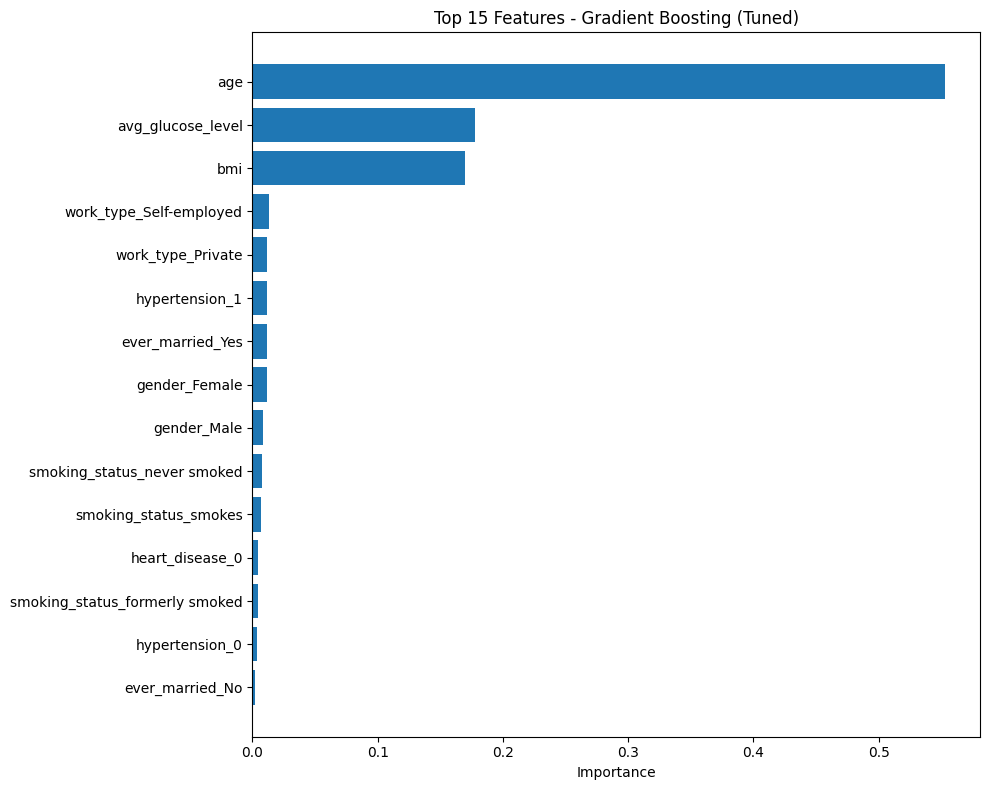

Top 10 Features:
                    feature  importance
                        age    0.553329
          avg_glucose_level    0.177648
                        bmi    0.169739
    work_type_Self-employed    0.013537
          work_type_Private    0.011777
             hypertension_1    0.011446
           ever_married_Yes    0.011273
              gender_Female    0.011273
                gender_Male    0.008190
smoking_status_never smoked    0.007609


In [12]:
# Feature importance
try:
    classifier = best_model.named_steps['classifier']
    preprocessor_fitted = best_model.named_steps['preprocessor']
    
    # Get feature names
    feature_names = (
        numeric_cols + 
        list(preprocessor_fitted.named_transformers_['cat']
             .get_feature_names_out(categorical_cols))
    )
    
    # Get importances
    importances = classifier.feature_importances_
    
    # Create DataFrame
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    # Plot
    plt.figure(figsize=(10, 8))
    top_features = feature_importance_df.head(15)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance')
    plt.title(f'Top 15 Features - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("Top 10 Features:")
    print(feature_importance_df.head(10).to_string(index=False))
    
except:
    print("Feature importance not available for this model type")

### Summary

In [13]:
print("="*60)
print("MODULE 05 COMPLETE - TREE TUNING SUMMARY")
print("="*60)
print(f"\nModels tuned:")
print("  1. Decision Tree (GridSearchCV)")
print("  2. Random Forest (RandomizedSearchCV)")
print("  3. Gradient Boosting (RandomizedSearchCV)")

print(f"\nResults:")
print(results.to_string(index=False))

print(f"\nBest Model: {best_model_name}")
print(f"Final Test ROC AUC: {test_auc:.4f}")

print(f"\nImprovement over baseline:")
improvement = ((test_auc - baseline_auc) / baseline_auc) * 100
print(f"  {improvement:.2f}% improvement")

print("\n✅ Ready for deployment (Module 05 scripts already created)")
print("="*60)

MODULE 05 COMPLETE - TREE TUNING SUMMARY

Models tuned:
  1. Decision Tree (GridSearchCV)
  2. Random Forest (RandomizedSearchCV)
  3. Gradient Boosting (RandomizedSearchCV)

Results:
                    Model  Validation ROC AUC
Gradient Boosting (Tuned)            0.852335
    Random Forest (Tuned)            0.840514
 Random Forest (Baseline)            0.836564
    Decision Tree (Tuned)            0.790916

Best Model: Gradient Boosting (Tuned)
Final Test ROC AUC: 0.8383

Improvement over baseline:
  0.21% improvement

✅ Ready for deployment (Module 05 scripts already created)
